# Binary Images

## by <span style="color:cornflowerblue"> Xueqing Tsang </a>

In [3]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

### Convert CSV to Image File

In [4]:
import pandas as pd
def read_csv(ifile, whitespace=False):
    ''' read a csv file or file with whitespace separators
        and return vx ubyte image file
        only 2D images supported
    '''
    if whitespace:
        df = pd.read_csv(ifile, header=None, sep='\s+')
    else:
        df = pd.read_csv(ifile, header=None, )
    return df.to_numpy(dtype='uint8', copy=True)

def read_img(ifile, flag=cv2.IMREAD_GRAYSCALE):
    return cv2.imread(ifile, flag)

In [5]:
"""
[dispmvx] uses the matplotlib package to create image presentations.

Parameters:
pvalues : boolean := True to specify that the numerical pixel values should be printed inside each pixel.
                     This is only suitable for small images (x image dimensions less than 40).
cmap : string := Color map of the image array. By default, cmap = "gray" to display grayscale image. To dislay color image,
                 let cmap = None.
"""
def dispmvx(imarray : np.ndarray, pvalues = False, cmap = "gray"):
    plt.imshow(imarray, cmap = cmap)
    if (pvalues and imarray.shape[0] <= 40 and imarray.shape[1] <= 40):
        for y in range(imarray.shape[0]):
            for x in range(imarray.shape[1]):
                plt.text(x, y, imarray[y,x],
                        ha = "center",
                        va = "center",
                        color = "white" if imarray[y,x] <= abs(imarray.max() - imarray.min())/2 else "black"
                        )
    plt.axis("off")
    plt.show()

In [6]:
"""
[embedim] embeds image numpy.array [imarray] with a border of zeros and returns transformed image array [tmarray]. 

Parameters:
dim : (left : int, right : int, lower : int, upper : int) := Border list tuple that defines the dimensions of the bounding
                                                             box of zeros that surrounds [imarray].
"""
def embedim(imarray : np.ndarray, dim):
    tmarray = np.zeros((dim[2] + imarray.shape[0] + dim[3], dim[0] + imarray.shape[1] + dim[1]), dtype = int)
    for y in range(imarray.shape[0]):
            for x in range(imarray.shape[1]):
                  tmarray[y+dim[3], x+dim[0]] = imarray[y,x]
    return tmarray

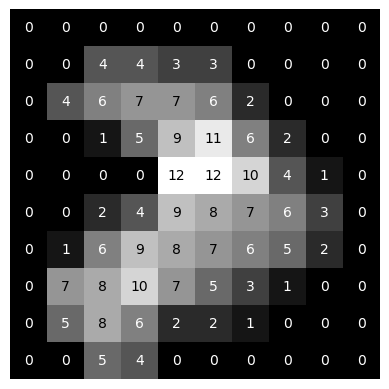

In [7]:
img = read_csv("blob.csv")
dispmvx(img, pvalues = True)

### boundpy
#### Program description
Assume 4-connected foreground and 8-connected background: if pixel value is 0, then background remains set to 0. If pixel value != 0, and if any of the 4-connected pixels adjacent to current pixel is a background, then set current pixel to segment boundary = 255. If pixel value != 0, and pixel not adjacent to any background, then set current pixel value to interior region pixel = 128.

In [8]:
def boundpy(imarray : np.ndarray, of):
    # Make 1 pixel bounding box around entire image array. [tm] is transformed matrix with 
    # 1 pixel bounding box: mapping T(x,y) such that x -> x+1, y -> y+1.
    im = np.copy(imarray)
    tm = embedim(im, (1,1,1,1))

    # Maps pixels in image [im] to either background, boundary, or interior pixel values.
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            if (tm[y+1,x+1] != 0):
                # Check if boundary:
                if (min(tm[y+1,x], tm[y,x], tm[y,x+1], tm[y,x+2], tm[y+1,x+2], tm[y+2,x+2], tm[y+2,x+1], tm[y+2,x]) == 0):
                    im[y,x] = 255
                else:
                    im[y,x] = 128
        
    cv2.imwrite(of, im)
    return im

#### Example of working program

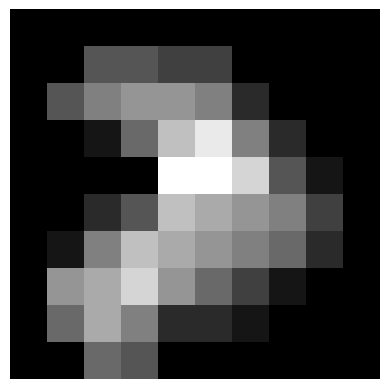

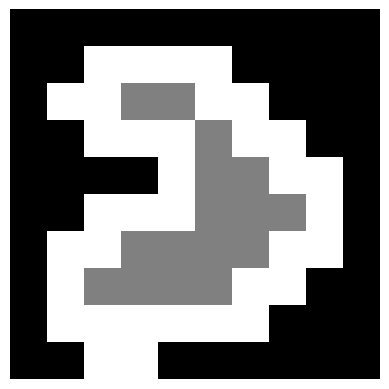

In [9]:
dispmvx(img)
dispmvx(boundpy(img, "blobbound.png"))

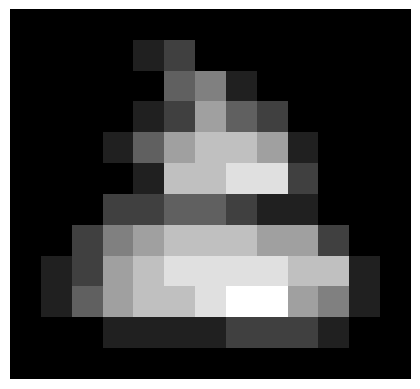

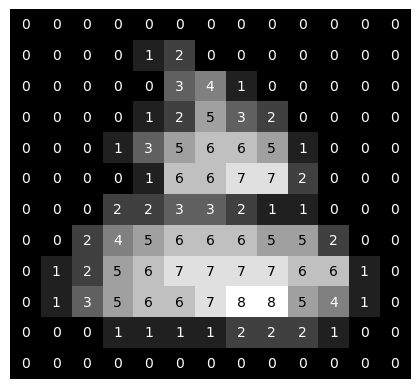

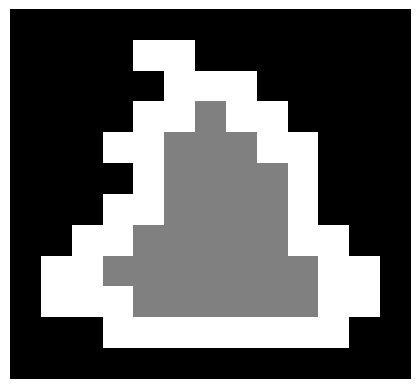

In [10]:
cloud = read_csv("cloud.csv")
dispmvx(cloud)
dispmvx(cloud, pvalues = True)
dispmvx(boundpy(cloud, "cloudbound.png"))

#### 4.4 Examples on full size images

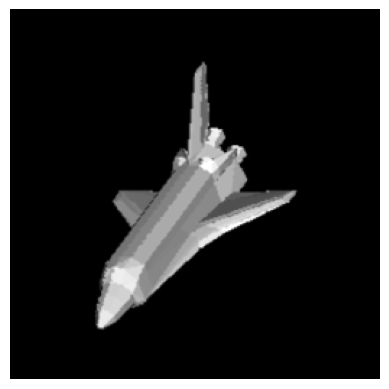

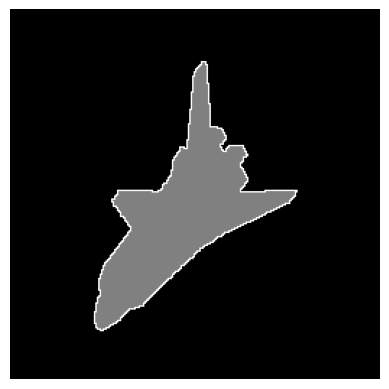

In [19]:
shuttle = read_img("shuttle.png")
dispmvx(shuttle)
dispmvx(boundpy(shuttle, "shuttlefast.png"), pvalues = True)

### slowlabel

#### Program description

In [11]:
#!/usr/bin/env python
""" slowlabel labels connected components with the recursive method.
    Is slow for large images.
"""

def slowlabel(imarray : np.ndarray, of):
    im = np.copy(imarray)
    tm = embedim(im, (1,1,1,1))

    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            im[y,x] = 0
    label = 1

    def setlabel(x : int, y : int, label : int):
        im[y,x] = label
        if (tm[y,x+1] != 0 and im[y-1,x] == 0): setlabel(x,y-1,label)
        if (tm[y+1,x+2] != 0 and im[y,x+1] == 0): setlabel(x+1,y,label)
        if (tm[y+2,x+1] != 0 and im[y+1,x] == 0): setlabel(x,y+1,label)
        if (tm[y+1,x] != 0 and im[y,x-1] == 0): setlabel(x-1,y,label)
      
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            # Search for unlabeled objects.
            if (tm[y+1,x+1] != 0 and im[y,x] == 0): 
                setlabel(x,y,label)
                label = label + 1
                
    cv2.imwrite(of, im)
    return im

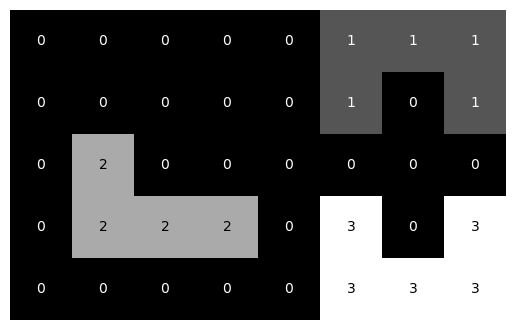

In [12]:
test = read_csv("testim4.csv")
dispmvx(slowlabel(test, "testim4slow.png"), pvalues = True)

### cclabel

### Program description
Let foreground be 4-connected, meaning that only pixels adjacent to the current pixel
will be considered part of the same object, and therefore, given the same label. The program [cclabel.py] labels connected components using a sequential method that iterates over all pixels in the input binary image twice.
First pass: when an object pixel is visited, the adjacent pixel above (Pu = im[y-1,x]) and to the left (Pl = im[y,x-1]) of the pixel (im[y,x]) are checked if labeled or not. If Pu or Pl are labeled, let im[y,x] = Pu or Pl. If neither Pu, Pl are labeled, assume im[y,x] is a new object, and give it a new label = label + 1. 
Second pass: sometimes Pu and Pl are both labeled. In the case that Pu != Pl for im[y,x], add to the equivalence table that labels Pu and Pl are equivalent, and set im[y,x] = Pu for now. During the second pass, merge all objects together with equivalent labels.

In [13]:
#!/usr/bin/env python
""" cclabel labels connected components with the sequential method.
    Runs faster than [slowlabel.py]
"""

def cclabel(imarray : np.ndarray, of):
    im = np.copy(imarray)
    tm = embedim(im, (1,1,1,1))

    # Set all pixels in [im] to 0.
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            im[y,x] = 0

    label = 0
    equiv_map = {} # [equiv_map] represents the equivalent table that shows equivalency relation between different labels.

    # First pass over the image array: for all object pixels, first checks if adjacent above (Pu) and left (Pl) pixels are labeled, and if they are, let im[y,x] = Pu or Pl. If neither Pu, Pl are labeled, assume im[y,x] is a new object, and give it a new label = label + 1.
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            # Search for unlabeled objects. If pixel unlabeled, check if Pl, Pu have labels. If not, create new label, else label pixel Pl or Pu.
            if (tm[y+1,x+1] != 0 and im[y,x] == 0): 
                # Give im[y,x] label Pu.
                if (im[y-1,x] != 0): 
                    im[y,x] = im[y-1,x]
                # Give im[y,x] label Pl.
                elif (im[y, x-1] != 0): im[y,x] = im[y,x-1]
                # If Pl, Pu do not have label, increment label.
                else:
                    label = label + 1
                    im[y,x] = label

                # If im[y,x] is an object, Pu and Pl have different labels, make labels Pu, Pl equivalent.
                if (im[y, x-1] != im[y-1, x] and min(im[y, x-1], im[y-1, x]) != 0): 
                    if (im[y, x-1] in equiv_map): 
                        equiv_map[im[y-1,x]] = equiv_map.get(im[y, x-1])
                    elif (im[y-1, x] in equiv_map): 
                        equiv_map[im[y,x-1]] = equiv_map.get(im[y-1, x])
                    else:
                        equiv_map[im[y, x-1]] = min(im[y, x-1], im[y-1, x])
                        equiv_map[im[y-1,x]] = min(im[y, x-1], im[y-1, x])

    # Second pass over the labeled image array: merge all objects together with equivalent labels.
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            if (im[y,x] in equiv_map): 
                # Give im[y,x] label Pu.
                im[y,x] = equiv_map.get(im[y,x])
                
    cv2.imwrite(of, im)
    return im


#### Small image tests
        

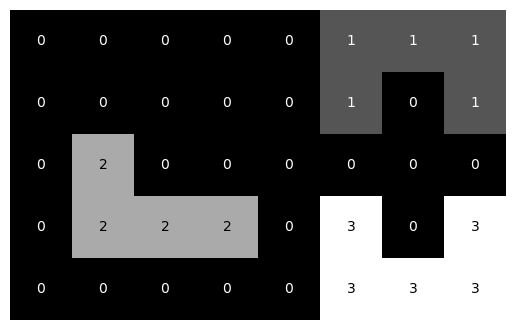

In [14]:
test = read_csv("testim4.csv")
dispmvx(cclabel(test, "testim4fast.png"), pvalues = True)

### Large image tests

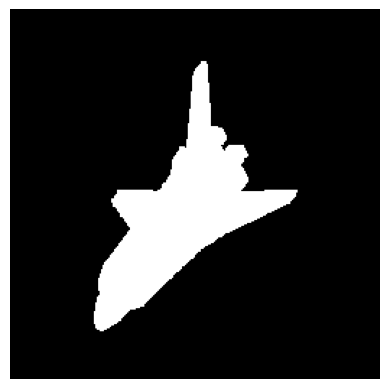

In [17]:
shuttle = read_img("shuttle.png")
dispmvx(cclabel(shuttle, "shuttlefast.png"), pvalues = True)